In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import os
import tensorflow.keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
from glob import glob
from PIL import Image,ImageOps
import tensorflow as tf

### Load Dataset


In [ ]:
BATCH_SIZE = 8

files_list1 = glob("/content/drive/MyDrive/ML1_Course_Project/audio_dataset/train_images/*")
files_list2 = glob("/content/drive/MyDrive/ML1_Course_Project/UTK_128/*")[:1000]

print(len(files_list1))


# Load Train Test
def get_dataset(files_list1,files_list2,size=(128,128)):
  secret = []
  cover = []
  
  cover_train = []
  secret_train = []

  cover_test = []
  secret_test = []

  trainSplit = 0.7
  secret_split = trainSplit * len(files_list1)
  cover_split = trainSplit * len(files_list2)

  for i in range(len(files_list2)):
    img_cover = Image.open(files_list2[i]).convert("RGB")
    # img_cover = img_cover.convert('YCbCr')
    img_cover = np.array(ImageOps.fit(img_cover,size),dtype=np.float32)
    img_cover /= 255.
    if i<200:
      img_secret = Image.open(files_list1[i]).convert("RGB")
      # img_secret = img_secret.convert('YCbCr')
      img_secret = np.array(ImageOps.fit(img_secret,size),dtype=np.float32)
      img_secret /= 255.
      secret_train.append(img_secret)
      cover_train.append(img_cover)
    elif i <800:
      secret_train.append(secret_train[i%200])
      cover_train.append(img_cover)
    else:
      img_secret = Image.open(files_list1[(i-800)%50]).convert("RGB")
      img_secret = np.array(ImageOps.fit(img_secret,size),dtype=np.float32)
      img_secret /= 255.
      secret_test.append(img_secret)
      cover_test.append(img_cover)
  
  cover_train, secret_train, cover_test, secret_test = np.array(cover_train) , np.array(secret_train), np.array(cover_test) , np.array(secret_test)  
  return cover_train, secret_train, cover_test, secret_test


250


In [ ]:
# Load and shuffle dataset
# cover_train, secret_train, cover_test, secret_test = get_dataset(files_list1, files_list2)
# print(cover_train.shape, secret_train.shape, cover_test.shape, secret_test.shape)

# def shuffle_dataset(a, b):
#     assert len(a) == len(b)
#     p = np.random.permutation(len(a))
#     return a[p], b[p]
  
# cover_train, secret_train = shuffle_dataset(cover_train, secret_train)
# cover_test, secret_test = shuffle_dataset(cover_test, secret_test)
# print(cover_train.shape, secret_train.shape, cover_test.shape, secret_test.shape)

# np.save("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Cover_Train.npy", cover_train)
# np.save("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Secret_Train.npy", secret_train)
# np.save("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Cover_Test.npy", cover_test)
# np.save("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Secret_Test.npy", secret_test)

In [ ]:
# Alternate load method
cover_train = np.load("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Cover_Train.npy")
secret_train = np.load("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Secret_Train.npy")
cover_test = np.load("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Cover_Test.npy")
secret_test = np.load("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Secret_Test.npy")
print(cover_train.shape, secret_train.shape, cover_test.shape, secret_test.shape)

(800, 128, 128, 3) (800, 128, 128, 3) (200, 128, 128, 3) (200, 128, 128, 3)


### Model Architecture

In [ ]:
# CNN Architecture

from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Activation, Dropout, Flatten, Dense

# def combined_model():
input_shape1 = Input(shape=(128, 128, 3), name = "Audio Image")
input_shape2 = Input(shape=(128, 128, 3), name = "Cover Image")

# Audio Feature Extraction
par1 = Conv2D(50, 3, padding='same', activation='relu')(input_shape1)
par1 = Conv2D(50, 3, padding='same', activation='relu')(par1)
par1 = Conv2D(50, 3, padding='same', activation='relu')(par1)
par1 = Conv2D(50, 3, padding='same', activation='relu')(par1)

par2 = Conv2D(50, 4, padding='same', activation='relu')(input_shape1)
par2 = Conv2D(50, 4, padding='same', activation='relu')(par2)
par2 = Conv2D(50, 4, padding='same', activation='relu')(par2)
par2 = Conv2D(50, 4, padding='same', activation='relu')(par2)

par3 = Conv2D(50, 5, padding='same', activation='relu')(input_shape1)
par3 = Conv2D(50, 5, padding='same', activation='relu')(par3)
par3 = Conv2D(50, 5, padding='same', activation='relu')(par3)
par3 = Conv2D(50, 5, padding='same', activation='relu')(par3)

pmerged = Concatenate(axis =3)([par1, par2, par3])

par3 = Conv2D(50, 5, padding='same', activation='relu')(pmerged)
par2 = Conv2D(50, 4, padding='same', activation='relu')(pmerged)
par1 = Conv2D(50, 3, padding='same', activation='relu')(pmerged)

pmerged = Concatenate(axis =3)([par3, par2, par1])

# Steganography Model
hmerged = Concatenate(axis =3)([input_shape2, pmerged])

har1 = Conv2D(50, 3, padding='same', activation='relu')(hmerged)
har1 = Conv2D(50, 3, padding='same', activation='relu')(har1)
har1 = Conv2D(50, 3, padding='same', activation='relu')(har1)
har1 = Conv2D(50, 3, padding='same', activation='relu')(har1)

har2 = Conv2D(50, 4, padding='same', activation='relu')(hmerged)
har2 = Conv2D(50, 4, padding='same', activation='relu')(har2)
har2 = Conv2D(50, 4, padding='same', activation='relu')(har2)
har2 = Conv2D(50, 4, padding='same', activation='relu')(har2)

har3 = Conv2D(50, 5, padding='same', activation='relu')(hmerged)
har3 = Conv2D(50, 5, padding='same', activation='relu')(har3)
har3 = Conv2D(50, 5, padding='same', activation='relu')(har3)
har3 = Conv2D(50, 5, padding='same', activation='relu')(har3)

hmerged = Concatenate(axis =3)([har1, har2, har3])

har3 = Conv2D(50, 5, padding='same', activation='relu')(hmerged)
har2 = Conv2D(50, 4, padding='same', activation='relu')(hmerged)
har1 = Conv2D(50, 3, padding='same', activation='relu')(hmerged)

hmerged = Concatenate(axis =3)([har3, har2, har1])
houtput = Conv2D(3, 1, padding='same')(hmerged)

# Extraction Model

rar1 = Conv2D(50, 3, padding='same', activation='relu')(houtput)
rar1 = Conv2D(50, 3, padding='same', activation='relu')(rar1)
rar1 = Conv2D(50, 3, padding='same', activation='relu')(rar1)
rar1 = Conv2D(50, 3, padding='same', activation='relu')(rar1)

rar2 = Conv2D(50, 4, padding='same', activation='relu')(houtput)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rar2)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rar2)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rar2)

rar3 = Conv2D(50, 5, padding='same', activation='relu')(houtput)
rar3 = Conv2D(50, 5, padding='same', activation='relu')(rar3)
rar3 = Conv2D(50, 5, padding='same', activation='relu')(rar3)
rar3 = Conv2D(50, 5, padding='same', activation='relu')(rar3)

rmerged = Concatenate(axis =3)([rar1, rar2, rar3])

rar3 = Conv2D(50, 5, padding='same', activation='relu')(rmerged)
rar2 = Conv2D(50, 4, padding='same', activation='relu')(rmerged)
rar1 = Conv2D(50, 3, padding='same', activation='relu')(rmerged)

rmerged = Concatenate(axis =3)([rar3, rar2, rar1])
routput = Conv2D(3, 1, padding='same')(rmerged)

reveal_model = Model(inputs=[input_shape1, input_shape2], outputs = [routput, houtput], name = "Network")


##### Visualize Model

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(reveal_model, to_file="DeepArchitecture.png")

### Train Model

In [ ]:
with tf.device('/device:GPU:0'):
  reveal_model.compile(optimizer='adam',loss = ["mse","mse"],loss_weights=[0.8, 1])
  history = reveal_model.fit([secret_train, cover_train], [secret_train, cover_train],epochs = 15, verbose = 1,validation_split=0.15,batch_size=8)

Epoch 1/15
85/85 [==============================] - 195s 2s/step - loss: 0.0370 - conv2d_46_loss: 0.0222 - conv2d_30_loss: 0.0193 - val_loss: 0.0176 - val_conv2d_46_loss: 0.0181 - val_conv2d_30_loss: 0.0031
Epoch 2/15
85/85 [==============================] - 174s 2s/step - loss: 0.0162 - conv2d_46_loss: 0.0147 - conv2d_30_loss: 0.0044 - val_loss: 0.0090 - val_conv2d_46_loss: 0.0069 - val_conv2d_30_loss: 0.0035
Epoch 3/15
85/85 [==============================] - 173s 2s/step - loss: 0.0095 - conv2d_46_loss: 0.0079 - conv2d_30_loss: 0.0031 - val_loss: 0.0351 - val_conv2d_46_loss: 0.0370 - val_conv2d_30_loss: 0.0054
Epoch 4/15
85/85 [==============================] - 173s 2s/step - loss: 0.0076 - conv2d_46_loss: 0.0060 - conv2d_30_loss: 0.0028 - val_loss: 0.0052 - val_conv2d_46_loss: 0.0040 - val_conv2d_30_loss: 0.0020
Epoch 5/15
85/85 [==============================] - 173s 2s/step - loss: 0.0055 - conv2d_46_loss: 0.0041 - conv2d_30_loss: 0.0022 - val_loss: 0.0054 - val_conv2d_46_loss: 0

### Save Model

In [ ]:
reveal_model.save('/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/ImageInImage_RGBModel.h5')
reveal_model.save_weights('/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/ImageInImage_RGBWeights.h5')

### Plot


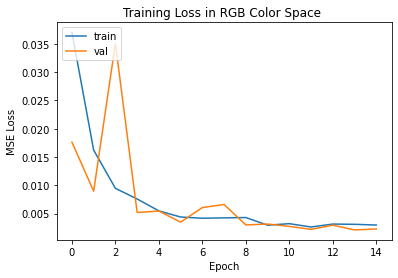

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss in RGB Color Space ')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('RGB.png')
plt.show()

### Testing phase

In [ ]:
# with tf.device('/device:GPU:0'):
observations = reveal_model.predict([secret_test, cover_test])
print(np.array(observations).shape)

(2, 200, 128, 128, 3)


### Visualize test results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Hidden Image')

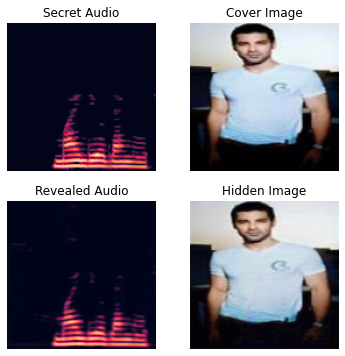

In [ ]:
import matplotlib.pyplot as plt
i = 3

fig = plt.figure(figsize=(6, 6))
fig.add_subplot(2, 2, 1)
plt.imshow(secret_test[i])
plt.axis('off')
plt.title("Secret Audio")
  
fig.add_subplot(2, 2, 2)
plt.imshow(cover_test[i])
plt.axis('off')
plt.title("Cover Image")
  
fig.add_subplot(2, 2, 3)
plt.imshow(observations[0][i])
plt.axis('off')
plt.title("Revealed Audio")
  
fig.add_subplot(2, 2, 4)
plt.imshow(observations[1][i])
plt.axis('off')
plt.title("Hidden Image")

### Loss Evaluation Metric

In [ ]:
import tensorflow as tf
# Calculate Loss
audio_loss = []
cover_loss = []
audio_psnr_o = []
audio_psnr_e = []
cover_psnr_o = []
cover_psnr_e = []
for i in range(secret_test.shape[0]):
  mse_secret = tf.keras.losses.mean_squared_error(secret_test[i], observations[0][i])
  mse_cover = tf.keras.losses.mean_squared_error(cover_test[i], observations[1][i])
  audio_loss.append(mse_secret)
  cover_loss.append(mse_cover)

  temp = np.square(np.max(secret_test[i]))
  temp = 10 * (np.log10(temp/mse_secret))
  audio_psnr_o.append(temp)

  temp = np.square(np.max(observations[0][i]))
  temp = 10 * (np.log10(temp/mse_secret))
  audio_psnr_e.append(temp)

  temp = np.square(np.max(cover_test[i]))
  temp = 10 * (np.log10(temp/mse_cover))
  cover_psnr_o.append(temp)

  temp = np.square(np.max(observations[1][i]))
  temp = 10 * (np.log10(temp/mse_cover))
  cover_psnr_e.append(temp)

In [ ]:
print(np.array(audio_loss).mean())
print(np.array(cover_loss).mean())
print(np.array(audio_psnr_o).mean())
print(np.array(audio_psnr_e).mean())
print(np.array(cover_psnr_o).mean())
print(np.array(cover_psnr_e).mean())

0.0024308667
0.000821204
42.493073
43.804707
33.81037
33.973854


In [ ]:
from skimage.metrics import structural_similarity as ssim
cover_test_ssim = []
secret_audio_test_ssim = []

for i in range(len(secret_test)):
  secret_audio_test_ssim.append(ssim(secret_test[i],observations[0][i],data_range=observations[0][i].max() - observations[0][i].min(),multichannel=True))
  cover_test_ssim.append(ssim(cover_test[i],observations[1][i],data_range=observations[1][i].max() - observations[1][i].min(),multichannel=True))

print("mean secret_audio_test_ssim:", np.array(secret_audio_test_ssim).mean())
print("mean cover_test_ssim:",np.array(cover_test_ssim).mean())

mean secret_audio_test_ssim: 0.8920192717280976
mean cover_test_ssim: 0.9466843418055366


# Load Saved Model and calcuate results on test set

In [ ]:
reconstructed_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/ImageInImage_RGBModel.h5')

In [ ]:
observations = reconstructed_model.predict([secret_test, cover_test])
print(np.array(observations).shape)

(2, 200, 128, 128, 3)


In [ ]:
np.save("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Hidden_Image_RGB.npy", observations[1])
np.save("/content/drive/MyDrive/ML1_Course_Project/ImageInImageData/Extracted_Audio_RGB.npy", observations[0])